In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# LOAD the datas

In [28]:
import os
import glob

base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_07'
video_path = glob.glob(os.path.join(base_path, 'videos', '*.mp4'))[0]
trc_file_path = glob.glob(os.path.join(base_path, 'opensim', '*.trc'))[0]
trc_output_file_path = f'{base_path}/preprocessing/output/filtered_trc_file.trc'

cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("total frames: ", total_frames)
cap.release()

total frames:  990


# Find out the sync marker in the video `.mp4`

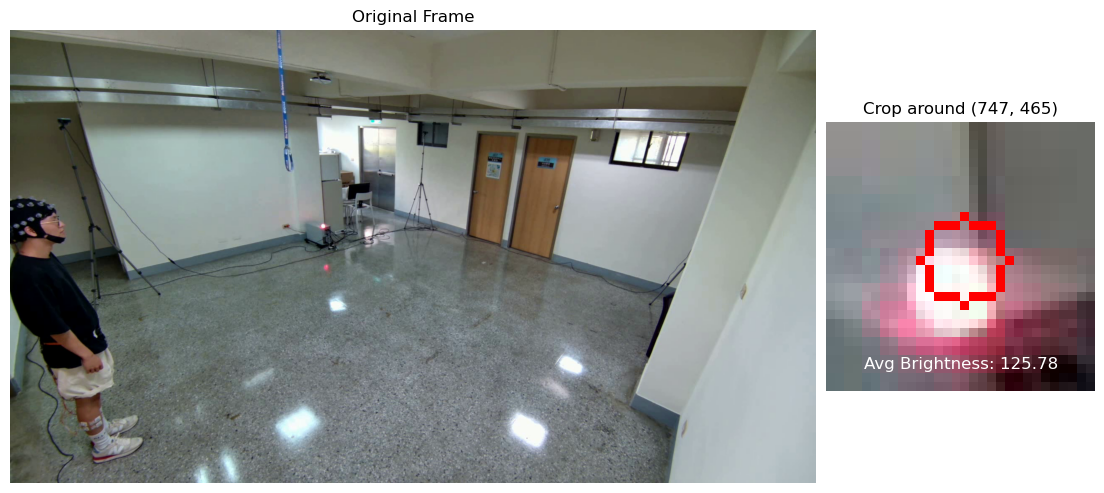

In [29]:
cap = cv2.VideoCapture(video_path)
frame_number = 591
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
ret, frame = cap.read()
cap.release()
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

lamp_x, lamp_y = 747, 465
half_size = 15
x_start = max(0, lamp_x - half_size)
x_end = min(frame.shape[1], lamp_x + half_size)
y_start = max(0, lamp_y - half_size)
y_end = min(frame.shape[0], lamp_y + half_size)
cropped_frame = frame[y_start:y_end, x_start:x_end]
cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
cropped_frame_gray = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2GRAY)
avg_brightness = np.mean(cropped_frame_gray)
THRESHOLD = avg_brightness
cropped_lamp_x = lamp_x - x_start
cropped_lamp_y = lamp_y - y_start
cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), radius=5, color=(255, 0, 0), thickness=1)


fig, axs = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

axs[0].imshow(frame_rgb)
axs[0].set_title('Original Frame')
axs[0].axis('off')
axs[1].imshow(cropped_frame_rgb)
axs[1].set_title(f'Crop around ({lamp_x}, {lamp_y})')
axs[1].axis('off')

axs[1].text(0.5, 0.1, f'Avg Brightness: {avg_brightness:.2f}', color='white',
            fontsize=12, ha='center', va='center', transform=axs[1].transAxes)
plt.subplots_adjust(wspace=0.02)
plt.show()

# the time of start blinking

In [31]:
brightness_values = []
red_values = []
green_values = []
frame_number = 0
max_offset = 30
initial_lamp_x = lamp_x
initial_lamp_y = lamp_y
enable_movement = False
enable_imageShow = True
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: Unable to open video file.")
    exit()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        if frame is None:
            print(f"End of video at frame {frame_number}")
        else:
            print(f"Error reading the frame at frame {frame_number}")
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    y_start = max(0, lamp_y - half_size)
    y_end = min(frame.shape[0], lamp_y + half_size)
    x_start = max(0, lamp_x - half_size)
    x_end = min(frame.shape[1], lamp_x + half_size)
    brightness_frame = gray_frame[y_start:y_end, x_start:x_end]

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(brightness_frame)
    if max_val > THRESHOLD and enable_movement:
        new_lamp_x = x_start + max_loc[0]
        new_lamp_y = y_start + max_loc[1]

        if abs(new_lamp_x - initial_lamp_x) > max_offset or abs(new_lamp_y - initial_lamp_y) > max_offset:
            print(f"Error: Lamp moved too far at frame {frame_number}")
            break
        else:
            lamp_x = new_lamp_x
            lamp_y = new_lamp_y
            # print(f"Lamp moved to ({lamp_x}, {lamp_y}) at frame {frame_number}")
        
    avg_brightness = np.mean(brightness_frame)
    brightness_values.append(avg_brightness)

    red_channel = frame[y_start:y_end, x_start:x_end, 2]
    green_channel = frame[y_start:y_end, x_start:x_end, 1]
    avg_red = np.mean(red_channel)
    avg_green = np.mean(green_channel)
    red_values.append(avg_red)
    green_values.append(avg_green)

    cropped_frame = frame[y_start:y_end, x_start:x_end]
    cropped_frame_rgb = cv2.cvtColor(cropped_frame, cv2.COLOR_BGR2RGB)
    cropped_lamp_x = max_loc[0]
    cropped_lamp_y = max_loc[1]
    cv2.circle(cropped_frame_rgb, (cropped_lamp_x, cropped_lamp_y), 5, (255, 0, 0), 2)
    if enable_imageShow:
        cv2.imshow("Cropped Frame with Lamp Detected", cropped_frame_rgb)

        # 檢查是否按下 'q' 鍵以退出
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break

    frame_number += 1

cap.release()
cv2.destroyAllWindows()

End of video at frame 990


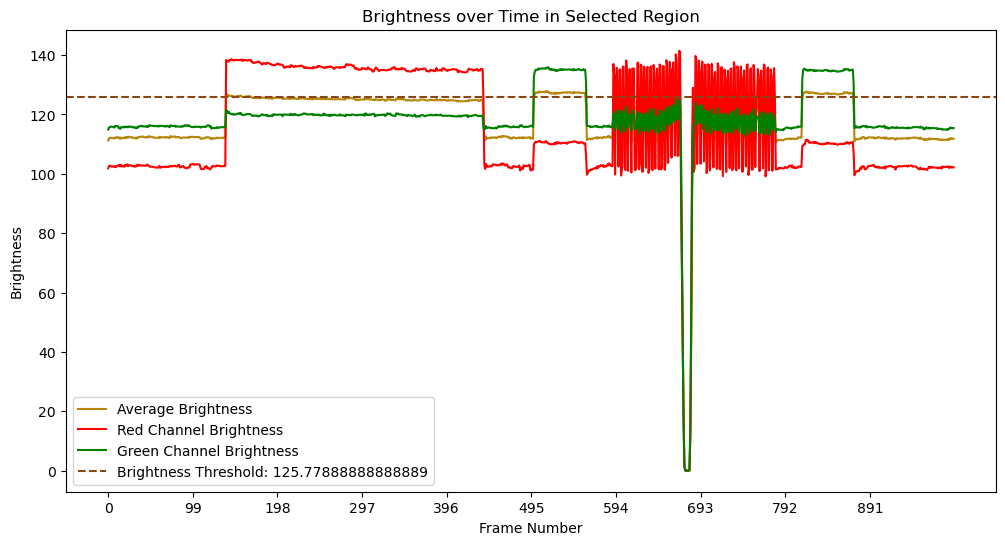

In [35]:
start = 0
end = total_frames
gap = (end - start) / 10
plt.figure(figsize=(12, 6))
plt.plot(np.arange(start, end), brightness_values[start:end], label='Average Brightness', color='darkgoldenrod')
plt.plot(np.arange(start, end), red_values[start:end], label='Red Channel Brightness', color='red')
plt.plot(np.arange(start, end), green_values[start:end], label='Green Channel Brightness', color='green')
plt.axhline(y=THRESHOLD, color='saddlebrown', linestyle='--', label=f'Brightness Threshold: {THRESHOLD}')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title('Brightness over Time in Selected Region')
plt.xticks(np.arange(start, end, gap))
plt.legend()
plt.show()


Wave ends at frame 591
Slope starts at frame 592 with value 132.64888888888888
First flicker starts at frame 593 with value 99.79


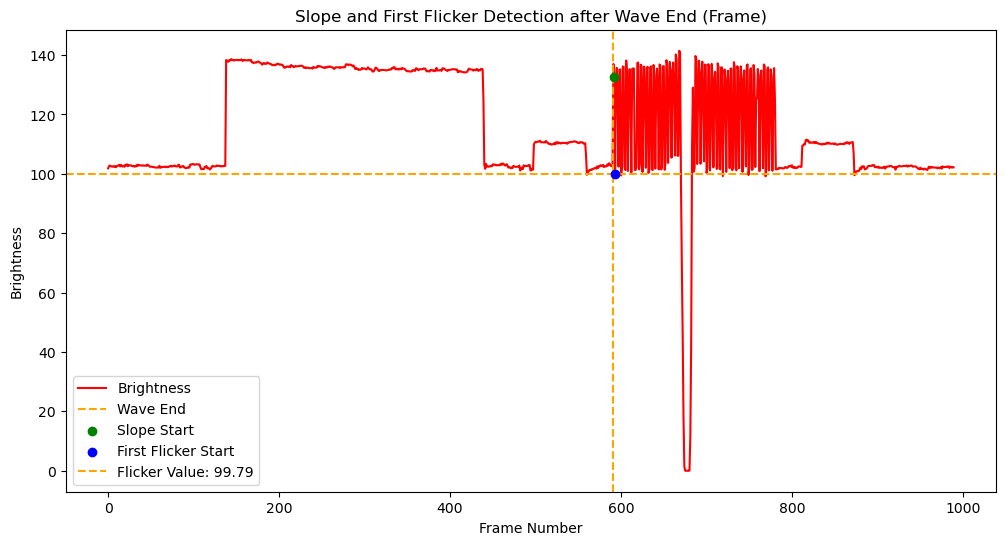

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 第一步：檢測區域和方波結束位置
def detect_region_and_wave_end(color_values, slope_threshold, jump_threshold):
    # 計算亮度變化的斜率
    color_slope = np.diff(color_values)

    # 檢測平滑區域，根據斜率變化小於 slope_threshold 的區域來劃分
    flat_regions = np.where(np.abs(color_slope) < slope_threshold)[0]

    # 根據平滑的區域，將數據分成三段，找到區域邊界
    boundaries = np.array_split(flat_regions, 3)
    region1_end = boundaries[0][-1]
    region2_end = boundaries[1][-1]

    # 找到 Region 2 End 之後的方波結束位置
    search_start = region2_end + 1

    # 從 Region 2 End 開始，找到第一個超過 jump_threshold 的點，作為方波結束的位置
    for i in range(search_start, len(color_slope)):
        if np.abs(color_slope[i]) > jump_threshold:
            wave_end_index = i + 1  # 因為斜率比亮度少一個點
            wave_end_value = color_values[wave_end_index]
            print(f"Wave ends at frame {wave_end_index}")
            return region1_end, region2_end, wave_end_index, wave_end_value

    print("No significant wave end found after Region 2.")
    return region1_end, region2_end, None, None

# 第二步：檢測坡度開始和第一次閃爍
def find_first_slope_before_flicker(color_values, threshold, start):
    # 計算亮度變化的斜率
    color_slope = np.diff(color_values)
    
    # 尋找第一個斜率大於閾值的點（第一次快速上升或下降）
    first_flicker_idx = np.where(np.abs(color_slope) > threshold)[0]
    
    if len(first_flicker_idx) > 0:
        flicker_start = first_flicker_idx[0] + 1  # +1 是因為斜率比亮度少一個點
        flicker_value = color_values[flicker_start]
        
        # 找到坡度變化的開始點（從第一次大於閾值之前開始回溯）
        first_slope_idx = first_flicker_idx[0]  # 預設為峰值位置
        for i in range(first_flicker_idx[0], 0, -1):
            if np.abs(color_slope[i]) < threshold:  # 找到小於閾值的點，表示斜率變化的開始
                first_slope_idx = i + 1  # +1 是因為這是斜率變化開始的點
                break

        # 這裡將結果加上 start，轉換成原始的幀數
        slope_start_frame = first_slope_idx + start
        flicker_start_frame = flicker_start + start
        slope_start_value = color_values[first_slope_idx]

        print(f"Slope starts at frame {slope_start_frame} with value {slope_start_value}")
        print(f"First flicker starts at frame {flicker_start_frame} with value {flicker_value}")
    else:
        print("No significant flicker or slope found.")
        slope_start_frame, slope_start_value = None, None
        flicker_start_frame, flicker_value = None, None
    
    return slope_start_frame, slope_start_value, flicker_start_frame, flicker_value

# 第三步：整合兩個功能，從方波結束後開始檢測
def analyze_brightness_wave_and_flicker(color_values, slope_threshold, jump_threshold, flicker_threshold):
    # 先檢測方波結束位置
    region1_end, region2_end, wave_end_index, wave_end_value = detect_region_and_wave_end(color_values, slope_threshold, jump_threshold)

    # 如果找到方波結束，則從該點開始繼續檢測第一次坡度變化和閃爍
    if wave_end_index is not None:
        start = wave_end_index
        end = len(color_values)  # 設置結束範圍（你也可以根據需要設置具體範圍）
        slope_start_frame, slope_start_value, flicker_start_frame, flicker_value = find_first_slope_before_flicker(color_values[start:end], flicker_threshold, start)

        # 繪製結果
        plt.figure(figsize=(12, 6))
        plt.plot(np.arange(len(color_values)), color_values, label='Brightness', color='red')
        
        # 標記方波結束位置
        plt.axvline(x=wave_end_index, color='orange', linestyle='--', label='Wave End')

        # 標記坡度變化開始
        if slope_start_frame is not None:
            plt.scatter(slope_start_frame, slope_start_value, color='green', label='Slope Start', zorder=5)
        
        # 標記第一次閃爍
        if flicker_start_frame is not None:
            plt.scatter(flicker_start_frame, flicker_value, color='blue', label='First Flicker Start', zorder=5)
            plt.axhline(y=flicker_value, color='orange', linestyle='--', label=f'Flicker Value: {flicker_value}')
        
        plt.xlabel('Frame Number')
        plt.ylabel('Brightness')
        plt.title(f'Slope and First Flicker Detection after Wave End (Frame)')
        plt.legend()
        plt.show()

# 設定參數並執行
slope_threshold = 10
jump_threshold = 10
flicker_threshold = 5

# 假設有一個 color_values 數據
analyze_brightness_wave_and_flicker(red_values, slope_threshold, jump_threshold, flicker_threshold)


1. find out plateau (plateau_threshold might should be dynamic)
2. trace back the nearest biggest slope

Highest plateau starts at frame 142 with value 138.335
Maximum slope change near highest plateau at frame 137


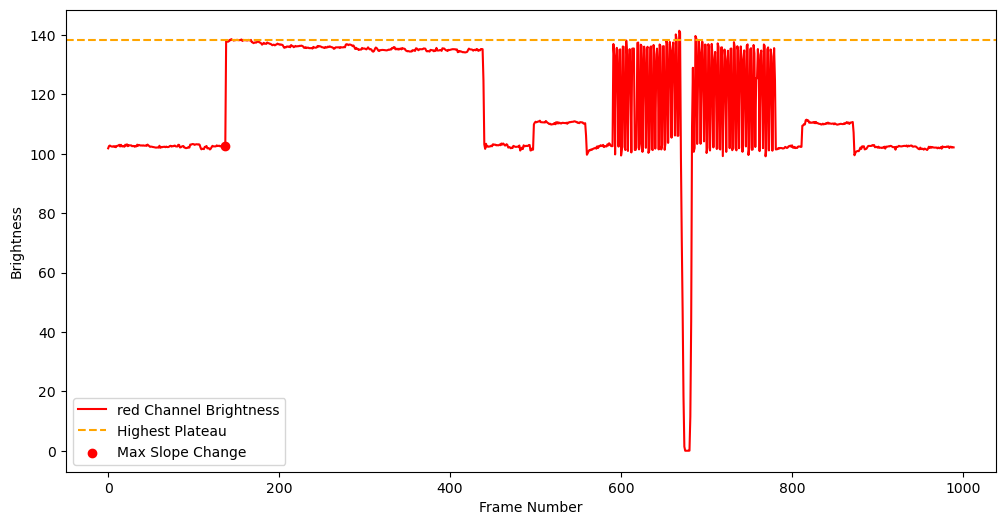

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_brightness(color):
    plateau_threshold = 5
    slope_threshold = 5

    window_size = 10
    color_values = eval(f"{color}_values")  # Assuming color_values are defined elsewhere in the namespace

    smoothed_color = np.convolve(color_values, np.ones(window_size)/window_size, mode='valid')

    plateau_mask = np.abs(np.diff(smoothed_color)) < plateau_threshold
    plateau_regions = np.where(plateau_mask)[0] + 1

    if len(plateau_regions) > 0:
        highest_plateau_idx = np.argmax(smoothed_color[plateau_regions])
        highest_plateau_start = plateau_regions[highest_plateau_idx]
        highest_plateau_value = smoothed_color[highest_plateau_start]
        print(f"Highest plateau starts at frame {highest_plateau_start} with value {highest_plateau_value}")
    else:
        print("No plateau found")

    color_slope = np.diff(color_values)

    slope_region_start = max(0, highest_plateau_start - window_size)
    slope_region_end = min(len(color_slope), highest_plateau_start + window_size)

    max_slope_idx = np.argmax(np.abs(color_slope[slope_region_start:slope_region_end]))
    max_slope_frame = slope_region_start + max_slope_idx

    print(f"Maximum slope change near highest plateau at frame {max_slope_frame}")

    plt.figure(figsize=(12, 6))
    plt.plot(color_values, color=color, label=f'{color} Channel Brightness')
    plt.axhline(y=highest_plateau_value, color='orange', linestyle='--', label='Highest Plateau')
    plt.scatter(max_slope_frame, color_values[max_slope_frame], color=color, label='Max Slope Change', zorder=5)
    plt.xlabel('Frame Number')
    plt.ylabel('Brightness')
    plt.legend()
    plt.show()

analyze_brightness('red')

# Archive

Wave ends at frame 639


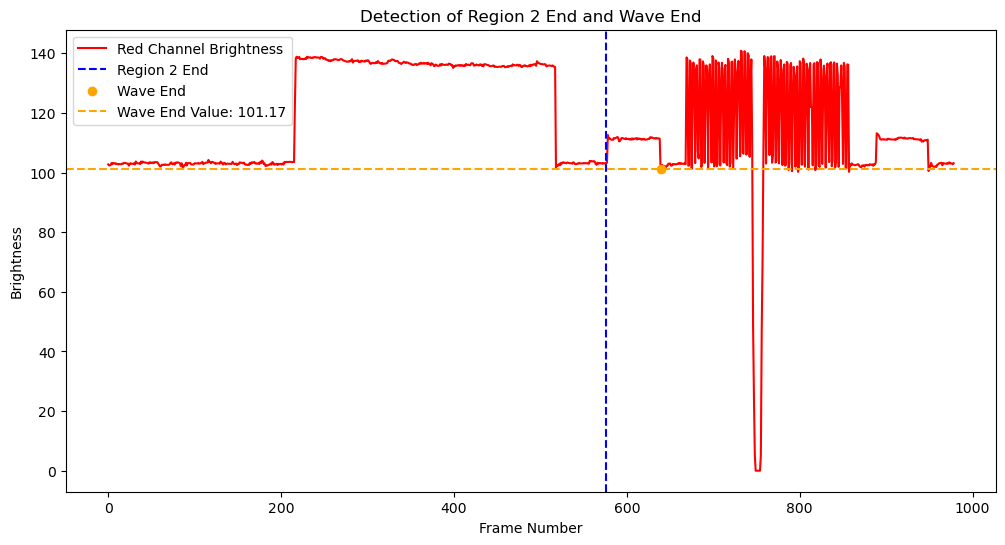

In [90]:
import numpy as np
import matplotlib.pyplot as plt

def detect_region_and_wave_end(color_values, slope_threshold, jump_threshold):
    # 計算亮度變化的斜率
    color_slope = np.diff(color_values)

    # 檢測平滑區域，根據斜率變化小於 slope_threshold 的區域來劃分
    flat_regions = np.where(np.abs(color_slope) < slope_threshold)[0]

    # 根據平滑的區域，將數據分成三段，找到區域邊界
    boundaries = np.array_split(flat_regions, 3)
    region1_end = boundaries[0][-1]
    region2_end = boundaries[1][-1]

    # 找到 Region 2 End 之後的方波結束位置
    search_start = region2_end + 1

    # 從 Region 2 End 開始，找到第一個超過 jump_threshold 的點，作為方波結束的位置
    for i in range(search_start, len(color_slope)):
        if np.abs(color_slope[i]) > jump_threshold:
            wave_end_index = i + 1  # 因為斜率比亮度少一個點
            wave_end_value = color_values[wave_end_index]
            print(f"Wave ends at frame {wave_end_index}")
            return region1_end, region2_end, wave_end_index, wave_end_value

    print("No significant wave end found after Region 2.")
    return region1_end, region2_end, None, None

# 設定斜率變化的閾值
slope_threshold = 10  # 方波穩定性的斜率閾值
jump_threshold = 10  # 方波結束後劇烈變化的斜率閾值

region1_end, region2_end, wave_end_index, wave_end_value = detect_region_and_wave_end(red_values, slope_threshold, jump_threshold)

# 繪製結果
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(red_values)), red_values, label='Red Channel Brightness', color='red')

# 標記藍色的分界點 (Region 2 End)
plt.axvline(x=region2_end, color='blue', linestyle='--', label='Region 2 End')

# 標記方波結束位置
if wave_end_index is not None:
    plt.scatter(wave_end_index, wave_end_value, color='orange', label='Wave End', zorder=5)
    plt.axhline(y=wave_end_value, color='orange', linestyle='--', label=f'Wave End Value: {wave_end_value}')
    
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title('Detection of Region 2 End and Wave End')
plt.legend()
plt.show()


Slope starts at frame 18 with value 102.80444444444444, time: 0.60 seconds
First flicker starts at frame 19 with value 138.59777777777776, time: 0.63 seconds


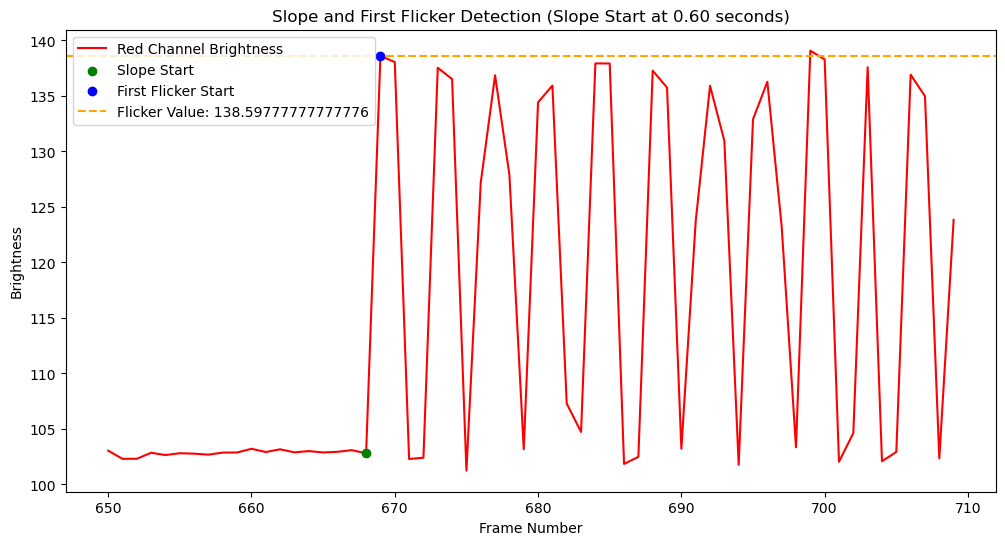

In [66]:
import numpy as np
import matplotlib.pyplot as plt

def find_first_slope_before_flicker(color_values, threshold, frame_duration):
    # 計算亮度變化的斜率
    color_slope = np.diff(color_values)
    
    # 尋找第一個斜率大於閾值的點（第一次快速上升或下降）
    first_flicker_idx = np.where(np.abs(color_slope) > threshold)[0]
    
    if len(first_flicker_idx) > 0:
        flicker_start = first_flicker_idx[0] + 1  # +1 是因為斜率比亮度少一個點
        flicker_value = color_values[flicker_start]
        flicker_time = flicker_start * frame_duration
        
        # 找到坡度變化的開始點（從第一次大於閾值之前開始回溯）
        first_slope_idx = first_flicker_idx[0]  # 預設為峰值位置
        for i in range(first_flicker_idx[0], 0, -1):
            if np.abs(color_slope[i]) < threshold:  # 找到小於閾值的點，表示斜率變化的開始
                first_slope_idx = i + 1  # +1 是因為這是斜率變化開始的點
                break

        slope_start_frame = first_slope_idx
        slope_start_value = color_values[slope_start_frame]
        slope_start_time = slope_start_frame * frame_duration

        print(f"Slope starts at frame {slope_start_frame} with value {slope_start_value}, time: {slope_start_time:.2f} seconds")
        print(f"First flicker starts at frame {flicker_start} with value {flicker_value}, time: {flicker_time:.2f} seconds")
    else:
        print("No significant flicker or slope found.")
        slope_start_frame, slope_start_value, slope_start_time = None, None, None
    
    return slope_start_frame, slope_start_value, slope_start_time, flicker_start, flicker_value, flicker_time

# 使用這個函數來找出坡度開始和第一個峰值
start = 650
end = 710
frame_duration = 1 / 30  # 假設每秒30幀


# 閥值可以根據數據大小進行調整
threshold = 5
slope_start_frame, slope_start_value, slope_start_time, flicker_start, flicker_value, flicker_time = find_first_slope_before_flicker(red_values[start:end], threshold, frame_duration)

# 繪製結果
plt.figure(figsize=(12, 6))
plt.plot(np.arange(start, end), red_values[start:end], label='Red Channel Brightness', color='red')
plt.scatter(slope_start_frame + start, slope_start_value, color='green', label='Slope Start', zorder=5)
plt.scatter(flicker_start + start, flicker_value, color='blue', label='First Flicker Start', zorder=5)
plt.axhline(y=flicker_value, color='orange', linestyle='--', label=f'Flicker Value: {flicker_value}')
plt.xlabel('Frame Number')
plt.ylabel('Brightness')
plt.title(f'Slope and First Flicker Detection (Slope Start at {slope_start_time:.2f} seconds)')
plt.legend()
plt.show()

# Check the blinking freq
this camera has Afterimage

# Read the TRC

In [3]:
import pandas as pd
try:
    trc_data = pd.read_csv(trc_file_path)
except pd.errors.ParserError:
    print("pandas_error")
    with open(trc_file_path, 'r') as file:
        trc_data = file.read()

trc_data

,PathFileType\t4\t(X/Y/Z)\tpath1_07_0-990.trc
0,DataRate\tCameraRate\tNumFrames\tNumMarkers\tU...
1,30\t30\t990\t22\tm\t30\t0\t990
2,Frame#\tTime\tHip\t\t\tRHip\t\t\tRKnee\t\t\tRA...
3,\t\tX1\tY1\tZ1\tX2\tY2\tZ2\tX3\tY3\tZ3\tX4\tY4...
4,1\t0.0333333333333333\t-1.7872415319972332\t0....
...,...
989,986\t32.86666666666667\t3.562179301014388\t0.7...
990,987\t32.9\t3.562179301014388\t0.77885418601719...
991,988\t32.93333333333333\t3.562179301014388\t0.7...
992,989\t32.96666666666667\t3.562179301014388\t0.7...


In [4]:
with open(trc_file_path, 'r') as file:
    trc_header = [next(file) for _ in range(4)]

camera_info_header = trc_header[1].strip().split('\t')
camera_info_values = trc_header[2].strip().split('\t')
camera_info = dict(zip(camera_info_header, camera_info_values))
camera_info

{'DataRate': '30',
 'CameraRate': '30',
 'NumFrames': '990',
 'NumMarkers': '22',
 'Units': 'm',
 'OrigDataRate': '30',
 'OrigDataStartFrame': '0',
 'OrigNumFrames': '990'}

In [5]:
header_line = trc_header[3].strip().split('\t')
cleaned_header = [col for col in header_line if col != '']
column_names = ['Frame#', 'Time'] + [f'{marker}_{axis}' for marker in cleaned_header[2:] for axis in ['X', 'Y', 'Z']]

In [6]:
trc_data = pd.read_csv(trc_file_path, sep='\t', skiprows=5, header=None)
trc_data.columns = column_names[:len(trc_data.columns)]
print(trc_data.columns)
trc_data

Index(['Frame#', 'Time', 'Hip_X', 'Hip_Y', 'Hip_Z', 'RHip_X', 'RHip_Y',
       'RHip_Z', 'RKnee_X', 'RKnee_Y', 'RKnee_Z', 'RAnkle_X', 'RAnkle_Y',
       'RAnkle_Z', 'RBigToe_X', 'RBigToe_Y', 'RBigToe_Z', 'RSmallToe_X',
       'RSmallToe_Y', 'RSmallToe_Z', 'RHeel_X', 'RHeel_Y', 'RHeel_Z', 'LHip_X',
       'LHip_Y', 'LHip_Z', 'LKnee_X', 'LKnee_Y', 'LKnee_Z', 'LAnkle_X',
       'LAnkle_Y', 'LAnkle_Z', 'LBigToe_X', 'LBigToe_Y', 'LBigToe_Z',
       'LSmallToe_X', 'LSmallToe_Y', 'LSmallToe_Z', 'LHeel_X', 'LHeel_Y',
       'LHeel_Z', 'Neck_X', 'Neck_Y', 'Neck_Z', 'Head_X', 'Head_Y', 'Head_Z',
       'Nose_X', 'Nose_Y', 'Nose_Z', 'RShoulder_X', 'RShoulder_Y',
       'RShoulder_Z', 'RElbow_X', 'RElbow_Y', 'RElbow_Z', 'RWrist_X',
       'RWrist_Y', 'RWrist_Z', 'LShoulder_X', 'LShoulder_Y', 'LShoulder_Z',
       'LElbow_X', 'LElbow_Y', 'LElbow_Z', 'LWrist_X', 'LWrist_Y', 'LWrist_Z'],
      dtype='object')


,Frame#,Time,Hip_X,Hip_Y,Hip_Z,RHip_X,RHip_Y,RHip_Z,RKnee_X,RKnee_Y,...,RWrist_Z,LShoulder_X,LShoulder_Y,LShoulder_Z,LElbow_X,LElbow_Y,LElbow_Z,LWrist_X,LWrist_Y,LWrist_Z
0,1,0.033333,-1.787242,0.801224,0.281349,-1.819006,0.782356,0.359656,-1.909386,0.464182,...,0.482821,-1.727942,1.309500,0.133345,-1.805938,1.033464,0.135882,-1.722578,0.816382,0.074560
1,2,0.066667,-1.787242,0.801224,0.281349,-1.819006,0.782356,0.359656,-1.909386,0.464182,...,0.482821,-1.727942,1.309500,0.133345,-1.805938,1.033464,0.135882,-1.722578,0.816382,0.074560
2,3,0.100000,-1.787242,0.801224,0.281349,-1.819006,0.782356,0.359656,-1.909386,0.464182,...,0.482821,-1.727942,1.309500,0.133345,-1.805938,1.033464,0.135882,-1.722578,0.816382,0.074560
3,4,0.133333,-1.787242,0.801224,0.281349,-1.819006,0.782356,0.359656,-1.909386,0.464182,...,0.482821,-1.727942,1.309500,0.133345,-1.805938,1.033464,0.135882,-1.722578,0.816382,0.074560
4,5,0.166667,-1.787242,0.801224,0.281349,-1.819006,0.782356,0.359656,-1.909386,0.464182,...,0.482821,-1.727942,1.309500,0.133345,-1.805938,1.033464,0.135882,-1.722578,0.816382,0.074560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,986,32.866667,3.562179,0.778854,0.417989,3.592489,0.748983,0.488738,3.666999,0.413999,...,0.540923,3.490785,1.291878,0.249932,3.502868,1.005137,0.226344,3.646255,0.783436,0.285452
986,987,32.900000,3.562179,0.778854,0.417989,3.592489,0.748983,0.488738,3.666999,0.413999,...,0.540923,3.490785,1.291878,0.249932,3.502868,1.005137,0.226344,3.646255,0.783436,0.285452
987,988,32.933333,3.562179,0.778854,0.417989,3.592489,0.748983,0.488738,3.666999,0.413999,...,0.540923,3.490785,1.291878,0.249932,3.502868,1.005137,0.226344,3.646255,0.783436,0.285452
988,989,32.966667,3.562179,0.778854,0.417989,3.592489,0.748983,0.488738,3.666999,0.413999,...,0.540923,3.490785,1.291878,0.249932,3.502868,1.005137,0.226344,3.646255,0.783436,0.285452


In [7]:
trc_data.iloc[216]

Frame#      217.000000
Time          7.233333
Hip_X        -1.787242
Hip_Y         0.801224
Hip_Z         0.281349
               ...    
LElbow_Y      1.033464
LElbow_Z      0.135882
LWrist_X     -1.722578
LWrist_Y      0.816382
LWrist_Z      0.074560
Name: 216, Length: 68, dtype: float64

990


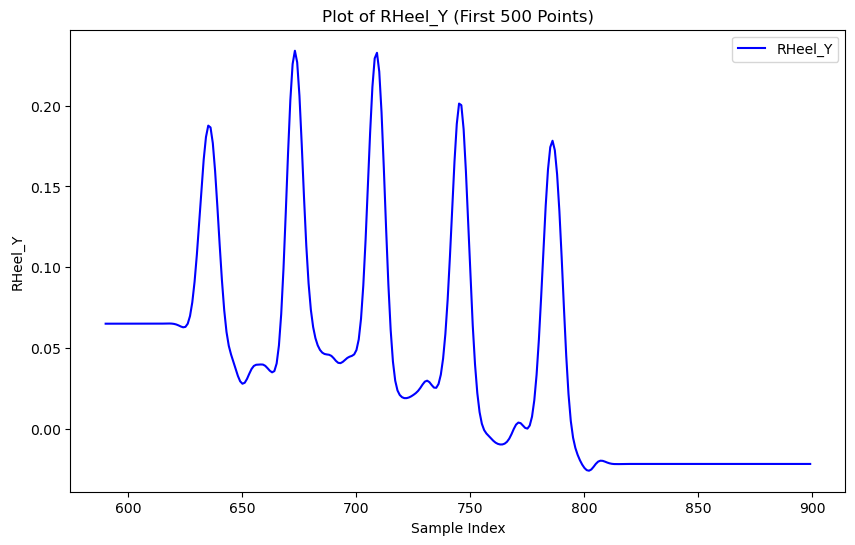

In [8]:
print(len(trc_data['RHeel_Y']))
start_flag = 590
end_flag = 900
rheel_y_sample = trc_data['RHeel_Y'][start_flag:end_flag]

# 繪製 RHeel_Y 數據
plt.figure(figsize=(10, 6))
plt.plot(rheel_y_sample.index, rheel_y_sample, label='RHeel_Y', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('RHeel_Y')
plt.title('Plot of RHeel_Y (First 500 Points)')
plt.legend()
plt.show()

In [9]:
from EMG_class import EMG_DATA
emg_data= EMG_DATA(base_path)
emg_data.read_emg_file(0)
# emg_data.process_data()
# emg_data.plot_emg("LTA", 0, 40.24, show_processed=False)

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF,Event Id,Event Date,Event Duration,Software Marker,Software Marker Name
0,0.000,1871569,-2804.34,-4113.88,9536.64,5735.55,-1382.95,2028.11,1713.53,6953.72,,,,,
1,0.001,1871570,-2795.36,-4106.52,9535.09,5738.71,-1382.84,2028.37,1712.9,6954.77,,,,,
2,0.002,1871571,-2786.86,-4098.95,9533.85,5741.16,-1382.73,2028.55,1712.37,6955.53,,,,,
3,0.003,1871572,-2779.83,-4091.69,9533.15,5742.63,-1382.62,2028.56,1712.0,6955.84,,,,,
4,0.004,1871573,-2775.79,-4086.11,9533.12,5743.42,-1382.54,2028.42,1711.84,6955.77,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42295,42.295,1913864,-2584.3,-4273.48,9505.51,5732.24,-1779.61,2367.73,1212.59,6858.61,,,,,
42296,42.296,1913865,-2584.46,-4273.1,9507.0,5734.91,-1766.68,2372.89,1212.78,6866.34,,,,,
42297,42.297,1913866,-2584.37,-4274.07,9508.59,5737.41,-1753.96,2382.41,1213.69,6872.17,,,,,
42298,42.298,1913867,-2584.06,-4276.22,9510.54,5738.54,-1741.28,2395.32,1215.17,6875.36,,,,,


In [10]:
emg_data.display_event_id_data()

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF,Event Id,Event Date,Event Duration,Software Marker,Software Marker Name
9850,9.850,1881419,-3041.66,-4305.38,9448.38,5732.58,-1969.24,2164.36,1697.57,7034.7,130,9.85,0,,
19856,19.856,1891425,-2878.14,-4243.38,9396.71,5678.73,-2032.4,2380.31,1495.37,6812.54,131,19.856,0,,
21858,21.858,1893427,-3035.79,-4280.09,9403.93,5637.75,-2006.99,2366.91,1432.53,6971.51,140,21.858,0,,
23859,23.859,1895428,-3113.52,-4311.88,9411.61,5624.5,-1957.92,2335.98,1387.68,6931.95,141,23.859,0,,
24866,24.866,1896435,-3141.46,-4329.07,9410.43,5638.18,-2050.05,2342.58,1274.8,6954.75,130,24.866,0,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31028,31.028,1902597,-2956.66,-4065.0,9250.07,5525.99,-2106.04,2329.01,1527.56,6737.16,130,31.028,0,,
31090,31.090,1902659,-3025.22,-4267.4,9808.38,5477.48,-1929.91,2411.31,1617.3,6628.41,131,31.09,0,,
31152,31.152,1902721,-2966.96,-4227.74,9136.21,5484.68,-1186.5,2245.48,1139.23,6905.21,131,31.152,0,,
32159,32.159,1903728,-2734.0,-4097.34,9514.99,5539.9,-1717.49,2466.99,1594.7,6675.81,140,32.159,0,,


In [16]:
first_event_index = emg_data.get_event_id_indices()[0]
last_event_index = emg_data.get_event_id_indices()[-1]
last_event_index-first_event_index
float(emg_data.our_data.iloc[last_event_index]['Timestamp'])-float(emg_data.our_data.iloc[first_event_index]['Timestamp'])
# print(first_event_index)
# emg_data.our_data = emg_data.our_data.iloc[first_event_index:]
# emg_data.our_data

24.309999999999995

In [11]:
emg_data_after_first_event = emg_data.process_data(normalize=True)

In [12]:
emg_data_after_first_event

,Timestamp,Serial Number,LGAST,RGAST,LTA,RTA,LBFL,RBFL,LRF,RRF
0,0.000,1871569.0,0.016397,0.048501,0.014227,0.019160,0.004113,0.002519,0.007051,0.000000
1,0.001,1871570.0,0.016708,0.048579,0.014167,0.019243,0.004196,0.002638,0.007116,0.000000
2,0.002,1871571.0,0.017019,0.048661,0.014107,0.019324,0.004279,0.002757,0.007181,0.000000
3,0.003,1871572.0,0.017329,0.048746,0.014047,0.019404,0.004362,0.002875,0.007248,0.000000
4,0.004,1871573.0,0.017638,0.048833,0.013988,0.019482,0.004445,0.002993,0.007315,0.000000
...,...,...,...,...,...,...,...,...,...,...
42295,42.295,1913864.0,0.005093,0.091495,0.036168,0.653351,0.078486,0.942417,0.090577,0.410346
42296,42.296,1913865.0,0.005093,0.091496,0.036168,0.653351,0.078485,0.942422,0.090577,0.410339
42297,42.297,1913866.0,0.005093,0.091497,0.036167,0.653352,0.078485,0.942425,0.090577,0.410333
42298,42.298,1913867.0,0.005093,0.091498,0.036167,0.653352,0.078485,0.942428,0.090577,0.410328


In [52]:
trc_start_time = trc_data['Time'].min()
trc_end_time = trc_data['Time'].max()
emg_start_time = emg_data_after_first_event.iloc[0]["Timestamp"]
emg_end_time = emg_data_after_first_event.iloc[-1]["Timestamp"]
print(f"TRC Data Time Range: {trc_start_time} to {trc_end_time}")
print(f"EMG Data Time Range: {emg_start_time} to {emg_end_time}")

TRC Data Time Range: 0.0333333333333333 to 33.0
EMG Data Time Range: 0.0 to 42.299


In [53]:
float(emg_end_time)-float(emg_start_time)

42.299

In [56]:
blink_time = trc_data.iloc[590-1]['Time']
print(blink_time)
print(len(trc_data))
print(len(emg_data_after_first_event))

19.666666666666668
990
42300


0.0333333333333333


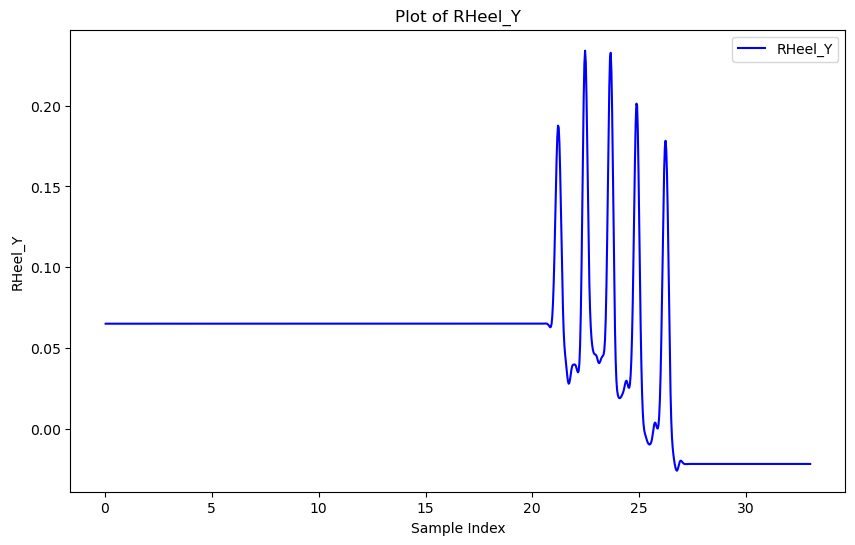

In [37]:
start_flag_external = trc_data['Time'].min()
print(start_flag_external)
end_flag_external = min(trc_end_time, emg_end_time)
plt.figure(figsize=(10, 6))
plt.plot(trc_data['Time'], trc_data['RHeel_Y'], label='RHeel_Y', color='blue')
plt.xlabel('Sample Index')
plt.ylabel('RHeel_Y')
plt.title('Plot of RHeel_Y')
plt.legend()
plt.show()

In [61]:
# trc_data.set_index('Time', inplace=True)
additional_data = {
    'data': trc_data['RKnee_Y'], 
    'label': 'RHeelY',
    'color': 'saddlebrown'
}

emg_data.plot_emg(
    muscle_name='RTA', 
    start_flag= blink_time, 
    end_flag=emg_end_time, 
    show_raw=False,
    show_processed=False, 
    show_envelope_raw=False, 
    show_normalized=True,
    additional_start_flag= blink_time,
    additional_end_flag=end_flag_external-10,
    additional_data=additional_data
)


KeyError: "None of ['Time'] are in the columns"

In [8]:
import numpy as np
import os
import glob
base_path = '../../mocap_EMG_EEG_data/data_An_Yu/path1_06'
npz_file_path = glob.glob(os.path.join(base_path, 'opensim', '*.npz'))[0]
sync_marker = np.load(npz_file_path)
sync_marker.files
sync_timeline = sync_marker['sync_timeline']
marker = sync_marker['marker']